In [ ]:
from pyhive import presto
from sqlalchemy import create_engine
from string import Template

class DataHandler:

    def __init__(self, params):
        self.params = params
        self.market = params['market']
        self.cnxn = self.connect_to_presto()
        self.engine = create_engine(f"presto://presto-{self.market}.taxibeat.com:8080/")

    def connect_to_presto(self):
        """
        Function to initialize connection with Presto database
        """
        try:
            cnxn = presto.connect(host=f"presto-{self.market}.taxibeat.com", port=8080)
        except presto.DatabaseError as err:
            print(f"Error: Could not make connection to Presto DB: {err}")
        return cnxn

    def execute_query(self, query):
        df = pd.read_sql_query(query, self.cnxn)
        return df
    
    def read_query(self, path):
        with open(path, "r") as f:
            query = f.read()
        return query
    
    def transform_query(self, query):
        query = Template(query)
        transformed_query = query.substitute(self.params)
        return transformed_query

    def drop_table(self, table_name):
        query = f"DROP TABLE IF EXISTS {table_name}"
        pd.read_sql_query(query, self.cnxn)

    def store_data(self, table_name, df, mode='replace'):
        df.to_sql(
            name=table_name,
            con=self.engine,
            if_exists=mode,
            index=False,
            chunksize=10000,
            method='multi'
        )
        
        
params={"country": "colombia",
        "market": "co"}

d = DataHandler(params)

df = d.execute_query(""" select * from
co.dna.underestimated_rides_raw_level_data limit 2000000
""")

In [1]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def integer_encode(df, variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)
    
def calculate_top_categories(df, variable, n=10):
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(n).index]

def one_hot_encode(df, variable, top_labels):
    for label in top_labels:
        df[variable + '_' + label] = np.where(df[variable] == label, 1, 0)
        
def frequency_encoding(df,variable):
    count_map = df[variable].value_counts().to_dict()
    df[variable + '_' + 'freq_encoding'] = df[variable].map(count_map) / len(df)
    
def find_freq_labels(data, variable, upper_tolerance, lower_tolerance):
    
    temp = data.groupby([variable])[variable].count() / len(data)
    
    high_freq = [x for x in temp.loc[temp>upper_tolerance].index.values]
    med_freq = [x for x in temp.loc[(temp>lower_tolerance) & (temp<upper_tolerance)].index.values]
    rare_freq = [x for x in temp.loc[temp<lower_tolerance].index.values]
    
    return high_freq, med_freq, rare_freq

def discretize(data, var, num_of_bins):
    disc, intervals = pd.qcut(
    data[var], num_of_bins, labels=['Q'+str(i) for i in range(1,num_of_bins+1)], 
    retbins=True, precision=3, duplicates='raise')

    data[var+'_discretized'] = disc
    
def remove_outlier(df, col_name, multiplier=1.5):
    q1 = df[col_name].quantile(0.01)
    q3 = df[col_name].quantile(0.91)
    iqr = q3 - q1 #Interquartile Range
    low_bound  = q1 - multiplier * iqr
    high_bound = q3 + multiplier * iqr
    df_out = df.loc[(df[col_name] > low_bound) & (df[col_name] < high_bound)]
    
    return df_out

def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used           to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Train, Validate", "Test"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4,             0.4, 0.2. The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data
    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. Train, Validate, Test)
        pos += 1
        if pos == len(stratify_values) - 1:
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportion
        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
    
    return df_stratified # Return the stratified, re-sampled data

def equal_sampling (data, col, randomstate):
    k = data[col].value_counts().min()
    df = data.groupby(col).apply(lambda x: x.sample(k,random_state=randomstate)) 
    df.index = df.index.droplevel(0)
    
    return df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#df.to_csv('distanceestimation_co_2.csv')
df = pd.read_csv('distanceestimation_co_2.csv').sort_values('created_local')
df.distance_actual = df.distance_actual / 1000
del df['Unnamed: 0']

In [4]:
df = df[df.distance_actual>1]

In [5]:
df['timestamp'] = pd.to_datetime(df.created_local)
df['date'] = pd.to_datetime(df.created_local).dt.date
df['time'] = pd.to_datetime(df.created_local).dt.time

df['hour'] = pd.to_datetime(df.created_local).dt.hour
df['minute'] = pd.to_datetime(df.created_local).dt.minute

df['weekday'] = pd.to_datetime(df.date).dt.weekday
df['dur_per_dist_est'] = df.estimate_duration/df.distance_est # Known value at the moment 
df['dur_per_dist_act'] = df.actual_duration_s/df.distance_actual # Known value at the end of the ride 

df['dur_error'] = df.actual_duration_s/df.estimate_duration - 1
df['dist_error'] = df.distance_actual/df.distance_est - 1

df['ratio_error'] = df.dur_per_dist_est/df.dur_per_dist_act - 1

In [42]:
df['target'] = np.where(df.dur_error < 0.1, 1, 0)

In [43]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error', 'target', 'OnD', 'id_driver_freq_encoding',
       'prone', 'service_Beat', 'service_Lite', 'service_Pronto',
       'service_Envío', 'service_Plus', 'service_Zero', 'target_drv_last',
       'target_ond_last', 'target_dest_last', 'target_orig_last'],
      dtype='object')

In [44]:
## TARGET VARIABLE

#df['under_est_dur'] = np.where(df.dur_error > 0.08, 1, 0)
#df['under_est_dist'] = np.where(df.dist_error > 0.3, 1, 0)

In [45]:
# Create the categorical variable
df['OnD'] = df.from_zone.astype('str') + '_' + df.to_zone.astype('str')
#frequency_encoding(df,'OnD')
#discretize(df,'OnD_freq_encoding',20)

#df['origin'] = df.from_zone.astype('str')
#df['destination'] = df.to_zone.astype('str')
#frequency_encoding(df,'origin')
#frequency_encoding(df,'destination')

frequency_encoding(df,'id_driver')
prone = df[df.target==1].groupby('id_driver')['id_city'].count().sort_values(ascending=False).head(30).index
df['prone'] = np.where(df.id_driver.isin(list(prone)),1,0)

one_hot_encode(df,'service',df.service.unique())
#one_hot_encode(df,'hour',df.hour.unique())

In [46]:
#df['timestamp_shift'] = df['timestamp'].shift(-1)
#df['time_delta'] = (df.timestamp_shift - df.timestamp) / pd.Timedelta(minutes=1)
#del df['timestamp_shift']

In [47]:
df[['dur_per_dist_est','dur_per_dist_act','ratio_error']]

dur_per_dist_est  dur_per_dist_act  ratio_error
0              101.612901         77.081251     0.318257
1              177.553199        186.544900    -0.048201
2              130.722153        126.406877     0.034138
3              170.325694        163.860911     0.039453
4              191.424190        208.056755    -0.079942
...                   ...               ...          ...
1960134        133.816866        159.840953    -0.162812
1960135        135.363636        155.150101    -0.127531
1960136        118.630681        185.433674    -0.360253
1960137        121.794876        135.293803    -0.099775
1960138         86.466163        112.213693    -0.229451

[1960139 rows x 3 columns]

### Get the last target values for drivers OnDs and Destinations

In [48]:
## For the Drivers

last_drv_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('id_driver', keep='last')\
                   [['id_driver','target']]
df = df.merge(last_drv_target.set_index('id_driver'),on='id_driver',suffixes=(None,'_drv_last'))

## For the OnDs

last_ond_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('OnD', keep='last')\
                   [['OnD','target']]
df = df.merge(last_ond_target.set_index('OnD'),on='OnD',suffixes=(None,'_ond_last'))

## For the Destinations

last_dest_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('to_zone', keep='last')\
                   [['to_zone','target']]
df = df.merge(last_dest_target.set_index('to_zone'),on='to_zone',suffixes=(None,'_dest_last'))

## For the Origins

last_orig_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('from_zone', keep='last')\
                   [['from_zone','target']]
df = df.merge(last_orig_target.set_index('from_zone'),on='from_zone',suffixes=(None,'_orig_last'))

In [49]:
#df[df.under_est_dur!=df.under_est_dur_drv_last][['under_est_dur','under_est_dur_drv_last']]

In [50]:
#df[df.under_est_dur!=df.under_est_dur_ond_last][['under_est_dur','under_est_dur_ond_last']]

In [51]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error', 'target', 'OnD', 'id_driver_freq_encoding',
       'prone', 'service_Beat', 'service_Lite', 'service_Pronto',
       'service_Envío', 'service_Plus', 'service_Zero', 'target_drv_last',
       'target_ond_last', 'target_dest_last', 'target_orig_last',
       'target_drv_last', 'target_ond_last', 'target_dest_last',
       'target_orig_last'],
      dtype='object')

In [52]:
db = remove_outlier(df,'distance_actual')

In [53]:
db.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error', 'target', 'OnD', 'id_driver_freq_encoding',
       'prone', 'service_Beat', 'service_Lite', 'service_Pronto',
       'service_Envío', 'service_Plus', 'service_Zero', 'target_drv_last',
       'target_ond_last', 'target_dest_last', 'target_orig_last',
       'target_drv_last', 'target_ond_last', 'target_dest_last',
       'target_orig_last'],
      dtype='object')

In [54]:
columns_to_exclude = ['created_local','id_ride', 'id_driver','actual_duration_s','distance_actual',
                      'distance_est','service','dur_error','dist_error','date','timestamp','time','OnD',
                      'from_zone','to_zone','date',
                      
                      #'OnD_freq_encoding',
                      'target_drv_last',
                      'target_ond_last', 
                      'target_dest_last','target_orig_last',
                      'dur_per_dist_act', 'ratio_error','dur_per_dist_act']

In [55]:
db = remove_outlier(db,'target')
db = db.replace([np.inf, -np.inf], np.nan).dropna()
db = db.drop(columns=columns_to_exclude).dropna()

In [56]:
#top_comb_drv = calculate_top_categories(df, 'id_driver', n=30)
#[str(x) for x in top_comb_drv]
#one_hot_encode(df, 'id_driver', [str(x) for x in top_comb_drv])

# Top-n OnD iteneraries (OnD)
#top_comb_ond = calculate_top_categories(df, 'OnD', n=70)
# One-Hot-Encoding the top-20 OnDs
#one_hot_encode(df, 'OnD', top_comb_ond)

In [57]:
#filter_col = [col for col in df if col.startswith('id_driver_')]

In [58]:
X = db.drop(['target'],axis=1)
y = db.target

# Forcing equal ratio on the binary variable
#X_y = equal_sampling(data=pd.concat([X,y],axis=1), col='target', randomstate=23)

#X_eq = X_y.drop(['target'],axis=1)
#y_eq = X_y['target']

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=23)

# Forcing equal ratio on the binary variable
#X_train, X_test, y_train, y_test = train_test_split(X_eq, y_eq, test_size=0.25,random_state=23)

In [60]:
db.target.value_counts(normalize=True)

1    0.555992
0    0.444008
Name: target, dtype: float64

In [61]:
y_train.value_counts(normalize=True)

1    0.556263
0    0.443737
Name: target, dtype: float64

In [62]:
y_test.value_counts(normalize=True)

1    0.555179
0    0.444821
Name: target, dtype: float64

In [63]:
X_train.isnull().sum()
X_train.columns#.describe()

Index(['id_city', 'estimate_duration', 'base_fare', 'surge_level',
       'pickup_eta', 'estimated_eta', 'hour', 'minute', 'weekday',
       'dur_per_dist_est', 'id_driver_freq_encoding', 'prone', 'service_Beat',
       'service_Lite', 'service_Pronto', 'service_Envío', 'service_Plus',
       'service_Zero'],
      dtype='object')

In [79]:
# Models

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

# Evaluation Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

models = []

#models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Rdg', RidgeClassifier()))
#models.append(('SVC', SVC()))
#models.append(('GNB', GaussianNB()))
#models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNC', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier()))

names, acc_scores, recall_scores, f1_scores = [], [], [], []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Model': names, 'Accuracy Score': acc_scores, 
                         'Recall Score': recall_scores, 'F1 Score': f1_scores})
tr_split

Model  Accuracy Score  Recall Score  F1 Score
0    RF        0.586962      0.742461  0.666214
1    GB        0.591820      0.861661  0.700952
2   XGB        0.601261      0.809884  0.692805

### Picking some Models

In [65]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=4,
                            min_samples_leaf=0.1,
                            max_features=None,
                            random_state=23)

dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
print('Accuracy of the classifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy of the classifier on test set: 0.57


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.25      0.34    209851
           1       0.58      0.82      0.68    261914

    accuracy                           0.57    471765
   macro avg       0.55      0.54      0.51    471765
weighted avg       0.56      0.57      0.53    471765



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


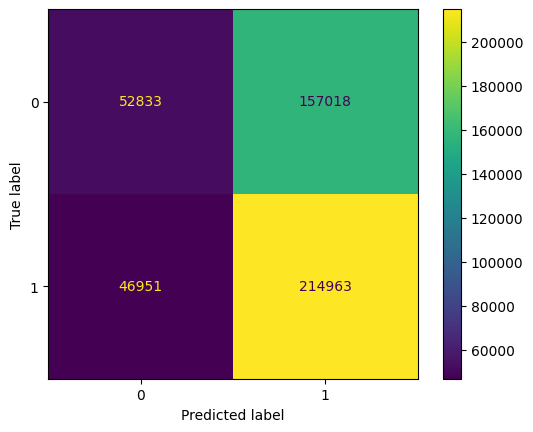

In [67]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(dt, X_test, y_test, values_format='')  
plt.show()

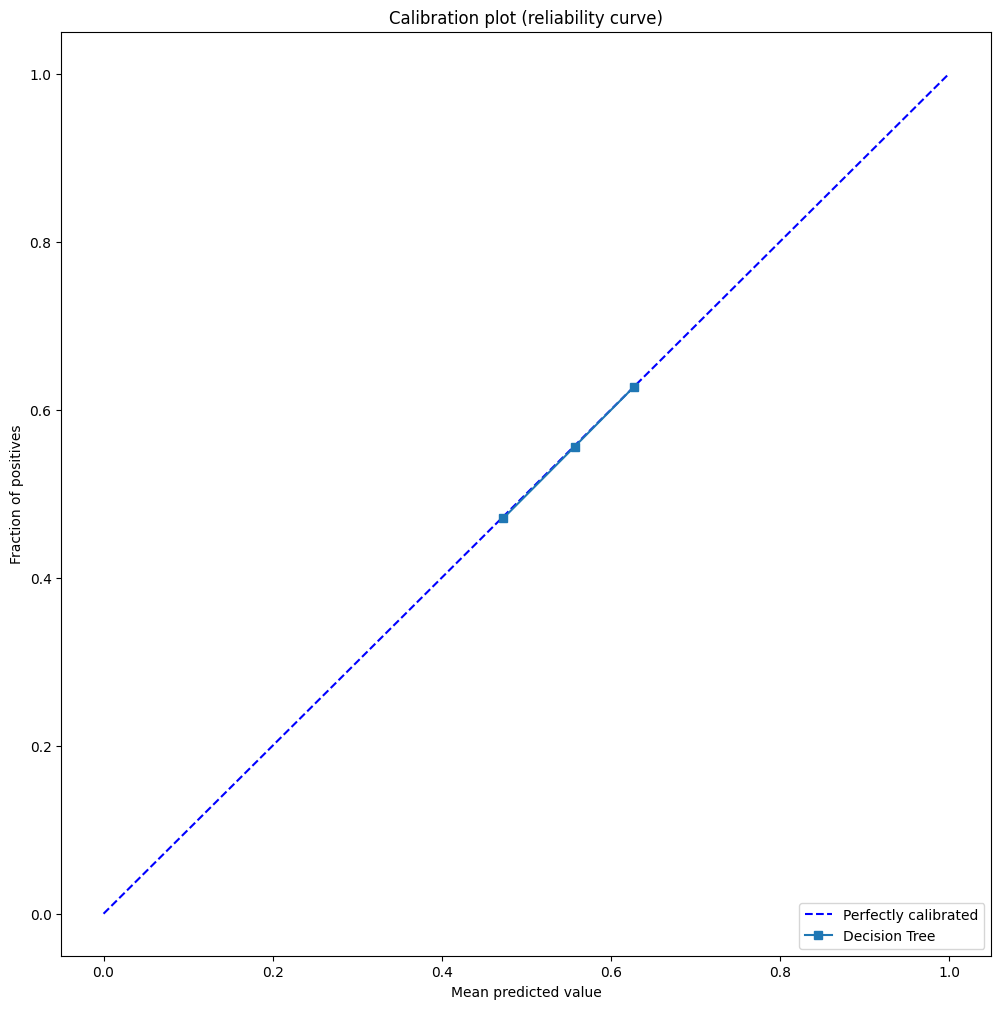

In [68]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_dt = dt.predict_proba(X_test)[:, 1]
fraction_of_positives_dt, mean_predicted_value_dt = calibration_curve(y_test, prob_pos_dt, n_bins=10)
ax.plot(mean_predicted_value_dt, fraction_of_positives_dt, "s-", label="%s" % ('Decision Tree'))

ax.legend(loc="lower right")
plt.show()

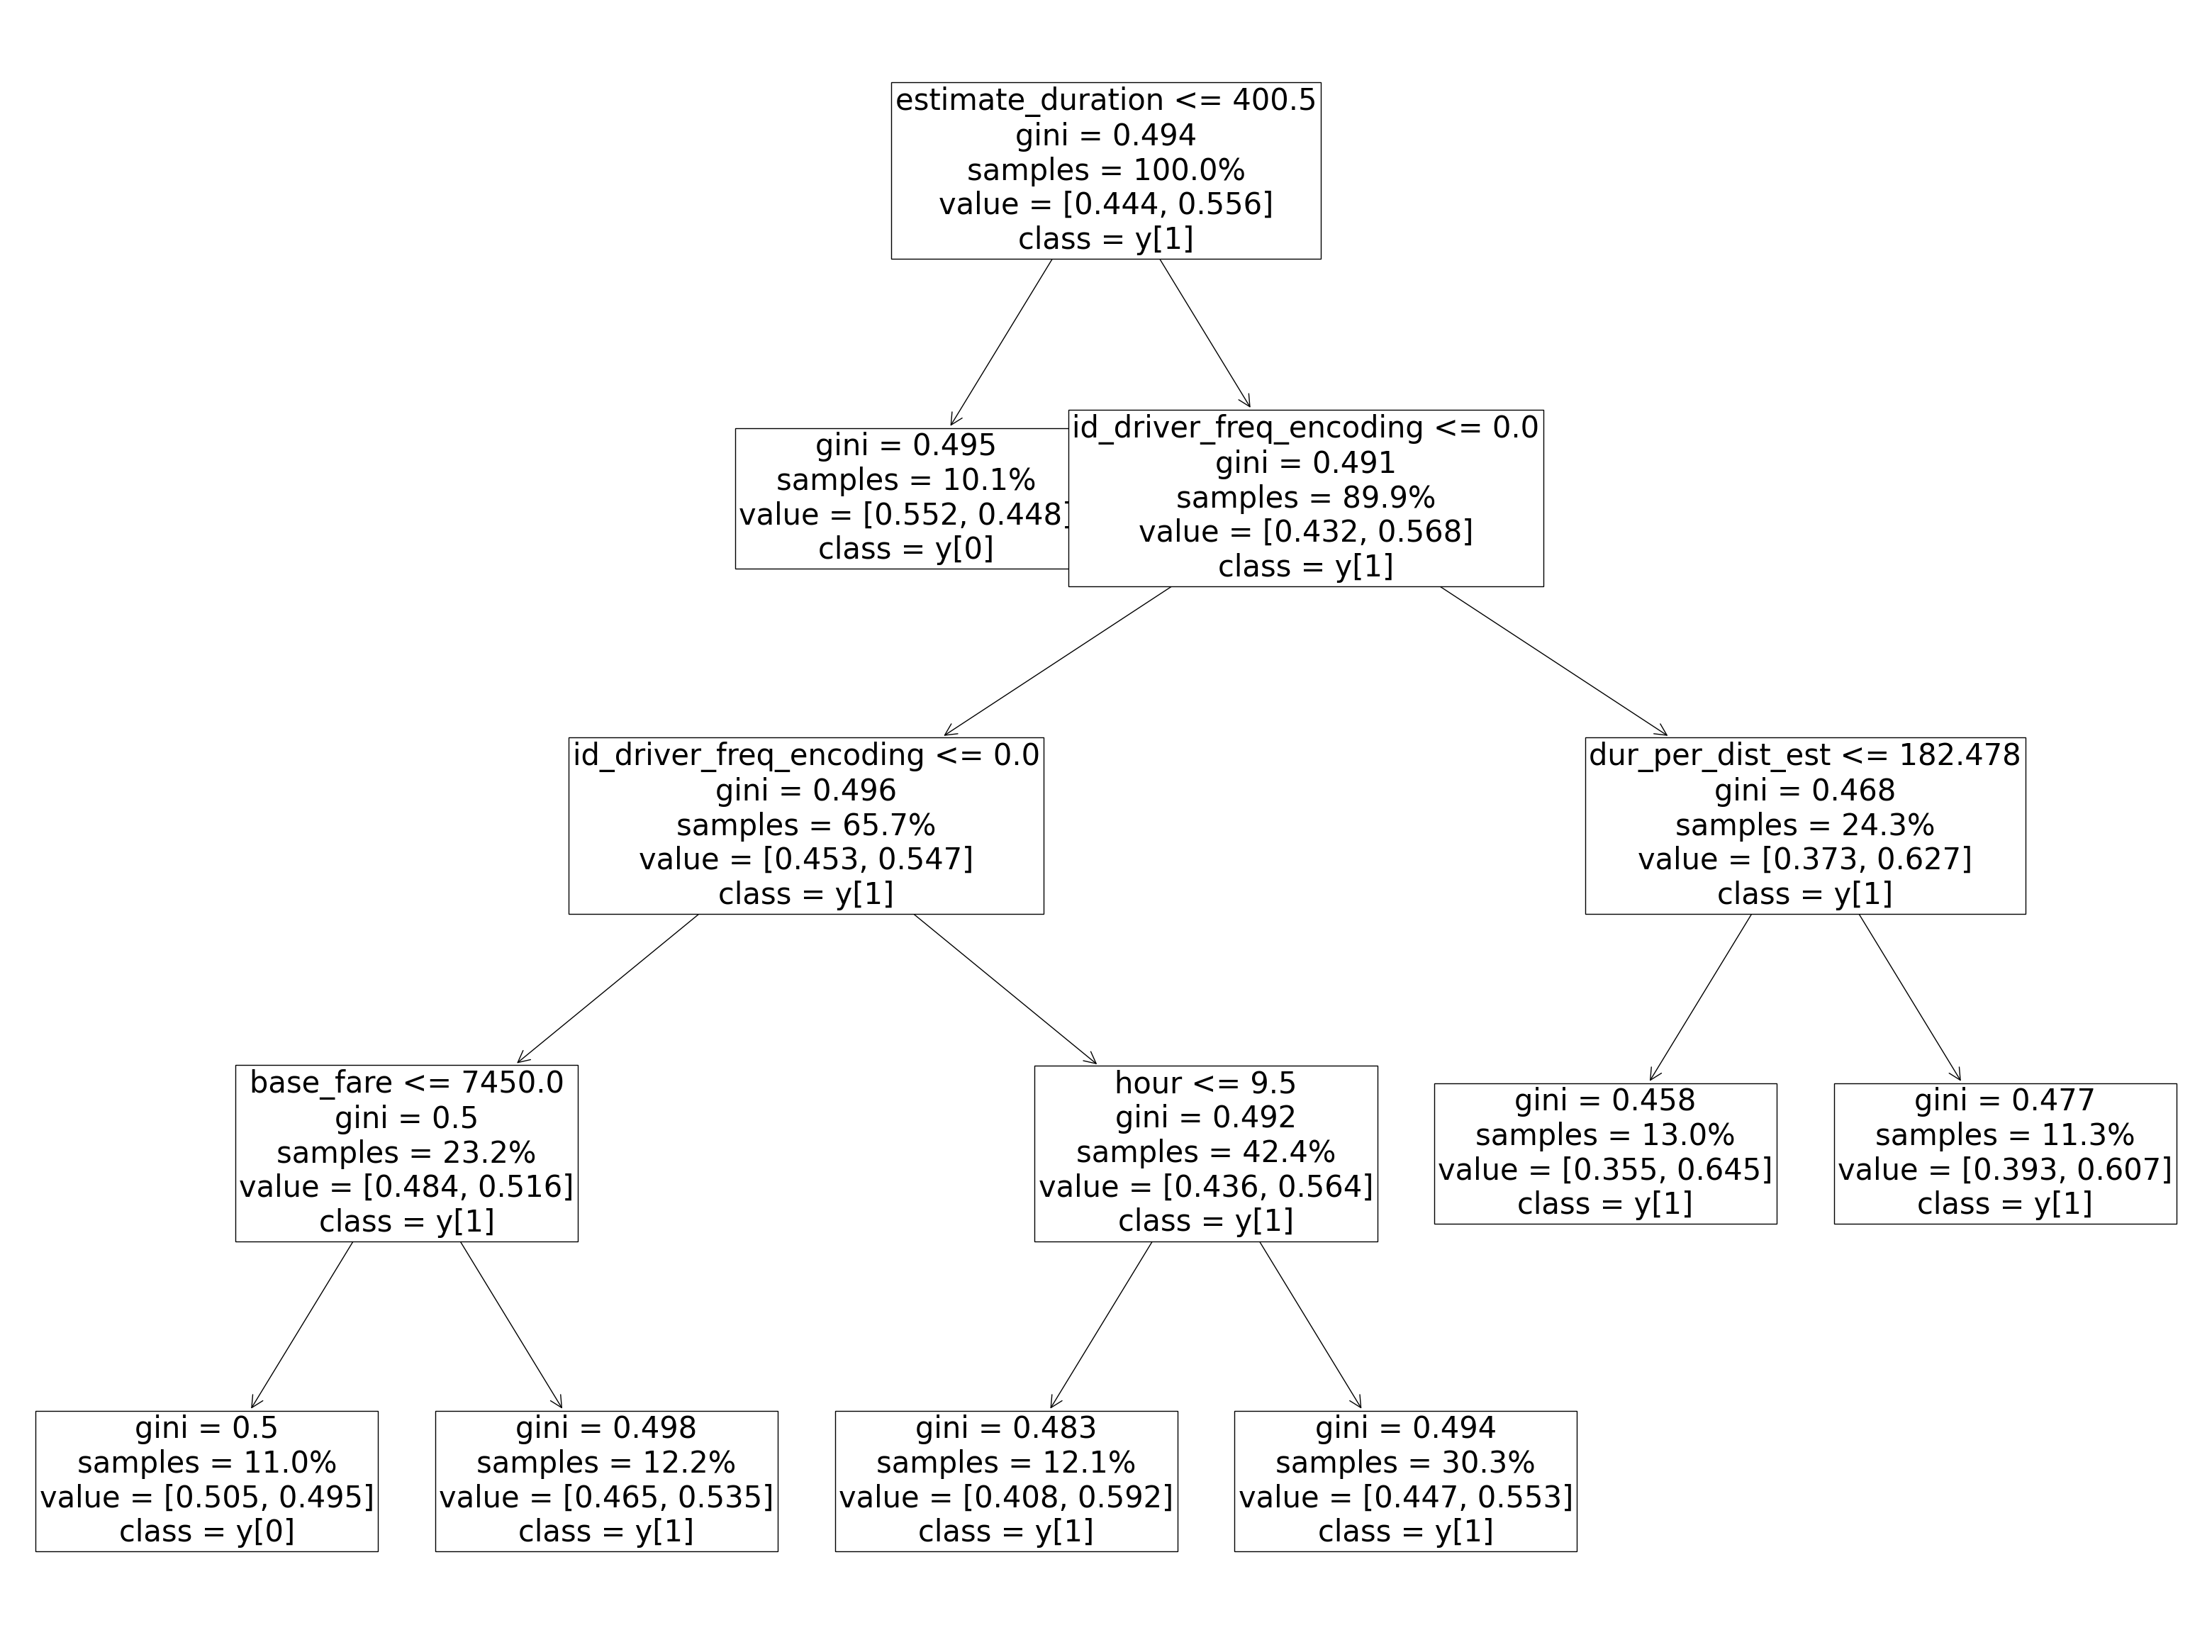

In [69]:
from sklearn import tree

plt.figure(figsize=(40,30))
tree.plot_tree(dt,max_depth=4,feature_names=X_test.columns,class_names=True,proportion=True,fontsize=30)
plt.show()

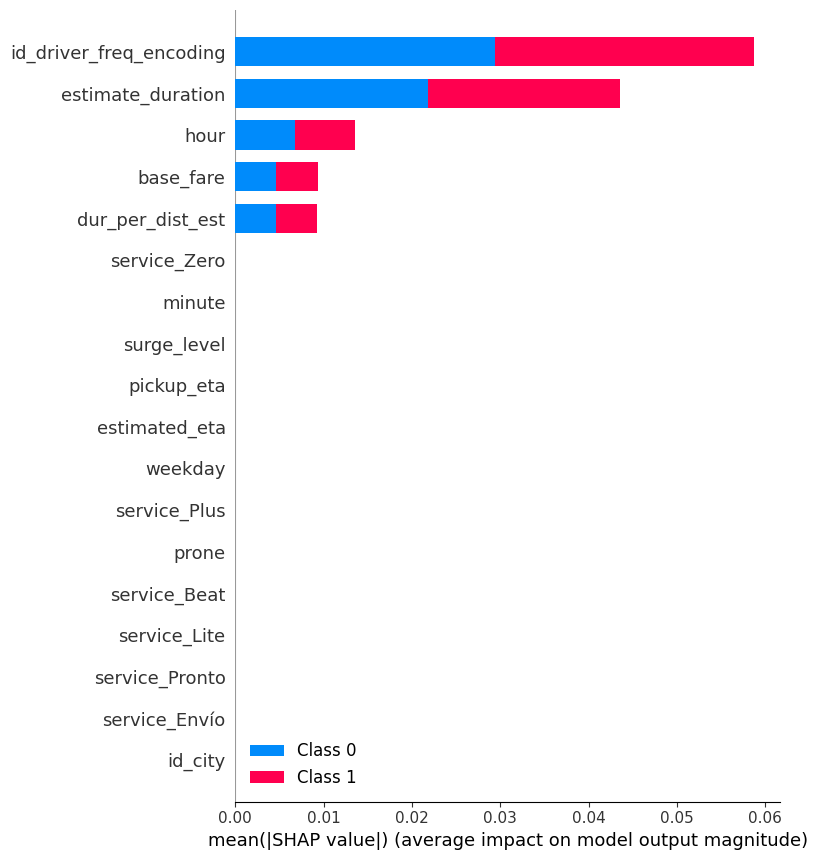

In [81]:
import shap
explainer = shap.TreeExplainer(dt)
shap_values_dt = explainer.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

In [71]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(n_estimators= 200,
                          learning_rate= 0.07,
                          random_state=23)
lgbm.fit(X_train, y_train)

y_pred=lgbm.predict(X_test)

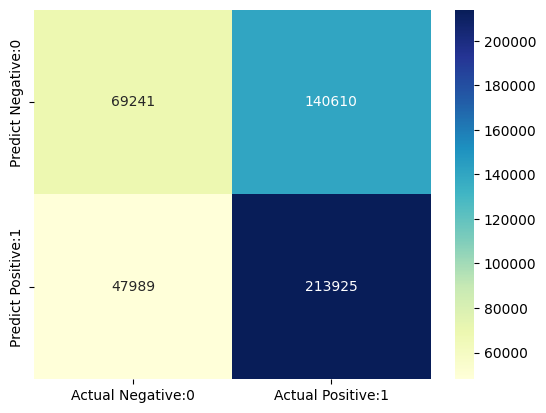

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                  index=['Predict Negative:0','Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.33      0.42    209851
           1       0.60      0.82      0.69    261914

    accuracy                           0.60    471765
   macro avg       0.60      0.57      0.56    471765
weighted avg       0.60      0.60      0.57    471765



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


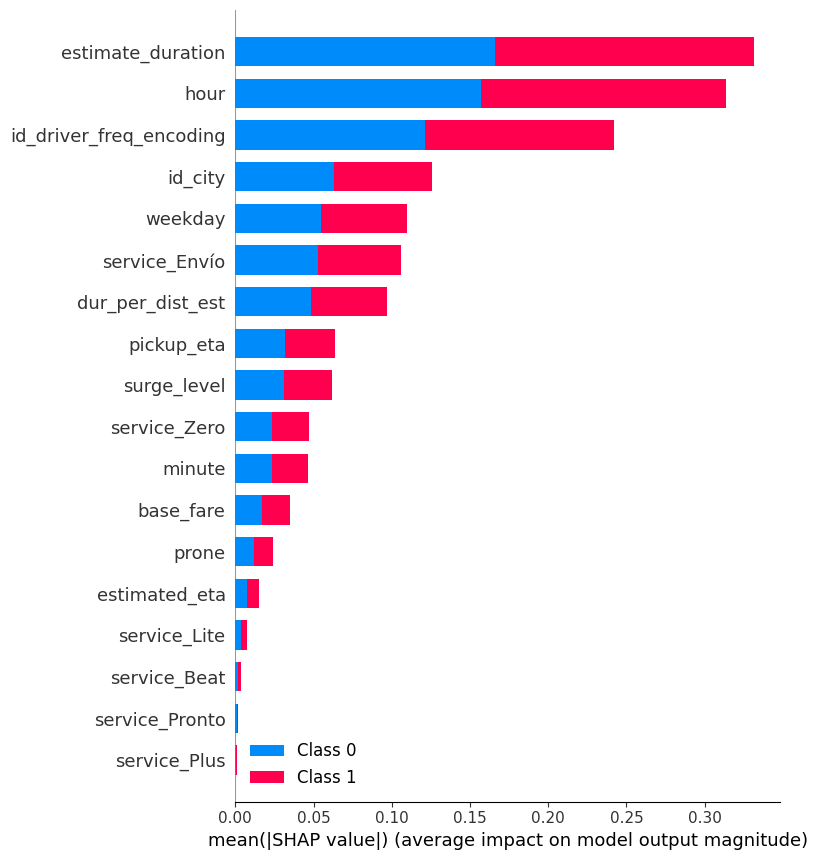

In [80]:
explainer = shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar")

In [74]:
lgbm._Booster.dump_model()["tree_info"]

[{'tree_index': 0,
  'num_leaves': 31,
  'num_cat': 0,
  'shrinkage': 1,
  'tree_structure': {'split_index': 0,
   'split_feature': 1,
   'split_gain': 8146.5498046875,
   'threshold': 339.50000000000006,
   'decision_type': '<=',
   'default_left': True,
   'missing_type': 'None',
   'internal_value': 0.22601,
   'internal_weight': 0,
   'internal_count': 1415292,
   'left_child': {'split_index': 5,
    'split_feature': 1,
    'split_gain': 2040.300048828125,
    'threshold': 235.50000000000003,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0.182772,
    'internal_weight': 20121.7,
    'internal_count': 81519,
    'left_child': {'split_index': 22,
     'split_feature': 1,
     'split_gain': 426.31201171875,
     'threshold': 192.50000000000003,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 0.13922,
     'internal_weight': 4176.69,
     'internal_count': 16921,
     'le

In [75]:
lgbm.booster_.trees_to_dataframe().dropna().sort_values(by='tree_index',ascending=True)

tree_index  node_depth node_index left_child right_child parent_index  \
1               0           2       0-S5      0-S22       0-S16         0-S0   
57              0           5      0-S21      0-L14       0-L22        0-S13   
54              0           6      0-S24      0-L15       0-L25        0-S14   
52              0           5      0-S14       0-L2       0-S24        0-S13   
51              0           4      0-S13      0-S14       0-S21        0-S12   
...           ...         ...        ...        ...         ...          ...   
12142         199           3    199-S10    199-S11     199-S13       199-S1   
12141         199           2     199-S1    199-S10      199-S2       199-S0   
12195         199           6     199-S8     199-S9      199-L9       199-S7   
12164         199           7    199-S22    199-S23     199-L23      199-S21   
12196         199           7     199-S9     199-L8     199-L10       199-S8   

           split_feature   split_gain     threshold decision_type  \
1      estimate_duration  2040.300049  2.355000e+02            <=   
57     estimate_duration   431.588989  5.815000e+02            <=   
54           surge_level   378.651001  3.750000e-01            <=   
52                  hour   973.114014  9.500000e+00            <=   
51                  hour   577.515991  1.850000e+01            <=   
...                  ...          ...           ...           ...   
12142               hour     8.734370  1.350000e+01            <=   
12141       service_Lite     7.721800  1.000000e-35            <=   
12195          base_fare     8.896250  6.350000e+03            <=   
12164               hour    10.718600  1.150000e+01            <=   
12196               hour     9.788110  2.250000e+01            <=   

      missing_direction missing_type     value     weight   count  
1                  left         None  0.182772  20121.700   81519  
57                 left         None  0.254845  18269.000   74013  
54                 left         None  0.234376  42823.300  173490  
52                 left         None  0.240837  68506.900  277542  
51                 left         None  0.243786  86775.900  351555  
...                 ...          ...       ...        ...     ...  
12142              left         None  0.000141  30283.700  130527  
12141              left         None  0.000638  37738.700  162557  
12195              left         None -0.007970    473.475    2019  
12164              left         None -0.006831   1822.300    7452  
12196              left         None -0.018505    214.678     908  

[5800 rows x 15 columns]

In [76]:
coeff = {'id_city':[1,1,1,1,2,2,2,3,3,3,4,4,4,6,6],
         'service':['Beat','Envio','Lite','Zero','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Lite'],
         'duration_coef_local':[119,1,108,840,124,0.1,111,172,0.1,162,90,2.75,84,124,114],
         'duration_coef_scaled_local':[621,644,565,0,660,714,596,613,676,537,798,785,751,436,388]}

In [77]:
df_coeff = pd.DataFrame(coeff)
df_coeff

id_city service  duration_coef_local  duration_coef_scaled_local
0         1    Beat               119.00                         621
1         1   Envio                 1.00                         644
2         1    Lite               108.00                         565
3         1    Zero               840.00                           0
4         2    Beat               124.00                         660
5         2   Envio                 0.10                         714
6         2    Lite               111.00                         596
7         3    Beat               172.00                         613
8         3   Envio                 0.10                         676
9         3    Lite               162.00                         537
10        4    Beat                90.00                         798
11        4   Envio                 2.75                         785
12        4    Lite                84.00                         751
13        6    Beat               124.00                         436
14        6    Lite               114.00                         388

In [ ]:
### WHAT THE MODEL PREDICTS AS UNDERESTIMATED  --> TREE MODEL PATH

class_1 = df[(df.estimate_duration<326.5) |
          ((df.estimate_duration>326.5) & (df.service_Envío<0.5) & (df.hour<18.5) & (df.hour>=9.5)) |
          ((df.service_Envío>0.5))]
class_1  

In [ ]:
len(class_1)/len(df)

In [ ]:
## WHAT THE MODEL WILL AFFECT FROM THE W

to_correctly_affect_1 = class_1[class_1.under_est_dur==1]
to_correctly_affect_1

In [ ]:
len(to_correctly_affect_1)/len(df)

In [ ]:
to_correctly_affect_1.base_fare.mean()

In [ ]:
to_wrongly_affect_0 = class_1[class_1.under_est_dur==0]
to_wrongly_affect_0

In [ ]:
len(to_wrongly_affect_0)/len(df)

In [ ]:
df.groupby(['id_city','service'])[['base_fare','actual_duration_s','dur_error']].agg(['median'])

In [ ]:
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 23,
                                    max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz

# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

xvar = X_test
feature_cols = X_test.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])

from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())